In [1]:
import mne
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from processing_functions import ppt_id, create_epochs, freq_ind, create_numeric_labels, relative_band_power
warnings.simplefilter('ignore')

In [7]:
def band_power(ppt_psd,freqs,freq_bands):
    indices = freq_ind(freqs,freq_bands)
    bands_list = []
    for i in range(len(indices)-1):
        bands_list.append((freqs[1]-freqs[0])*np.sum(ppt_psd[:,indices[i]:indices[i+1],:],axis=1,keepdims=True))
    return np.transpose(np.squeeze(np.array(bands_list)),(1,0,2))


The following piece of code creates numerical labels for the target variable: 0 for Alzheimer's, 1 for Frontotemporal dementia, and 2 for healthy group

In [2]:
ppt_diagnostics = pd.read_csv('data/ds004504/participants.tsv',sep='\t')
target_labels = ppt_diagnostics['Group'].apply(create_numeric_labels).values
target_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

The general pipeline is to import the data for the patient, create epochs of 4 s each with 50 percent overlap, then compute the average power spectrum for each of the five bands for all 19 channels, so we end up with $19*5 = 95$ features for each epoch. We then train a three nearest neighbor classifier on the patients. We choose leave one patient out cross validation, so we will train on all but one patients and test the accuracy of the method on this last patient. We record the accuracy of every run and then in the end, calculate the mean and the standard deviation of the procedure. 

In [3]:
epoch_length = 2000
overlap_ratio = 0.5
freq_bands = np.array([0.5,4.0,8.0,13.0,25.0,45.0])
sample_freq = 500 #hertz

In [4]:
ppt = 1
raw_data = mne.io.read_raw_eeglab('data/ds004504/derivatives/' + ppt_id(ppt)
                                  + '/eeg/' + ppt_id(ppt) + '_task-eyesclosed_eeg.set', preload = True)

In [5]:
export = raw_data.to_data_frame()
ppt_array = export.iloc[:,range(1,len(export.columns))].values
del raw_data
del export
ppt_epochs = create_epochs(ppt_array,epoch_length,overlap_ratio)
freqs, ppt_psd  = welch(ppt_epochs,fs=sample_freq, axis=1)

In [14]:
indices = freq_ind(freqs,freq_bands)
indices

[1, 3, 5, 7, 13, 24]

In [16]:
ppt_psd[4,indices[0]:indices[-1],4]

array([58.53699924, 24.62876712,  7.61911437,  2.22494087,  1.55793328,
        2.88881974,  1.50681211,  1.09845937,  0.72250541,  0.61191937,
        0.47813142,  0.47287542,  0.45897409,  0.2893695 ,  0.19548259,
        0.14721017,  0.18780827,  0.16157107,  0.12615223,  0.13499466,
        0.12111435,  0.10868682,  0.06256057])

In [ ]:
indices = freq_ind(freqs,freq_bands)
total_power = np.sum(ppt_psd[:,indices[0]:indices[-1],:],axis=1,keepdims=True)
relative_bands_list = []
for i in range(len(indices)-1):
    relative_bands_list.append(np.sum(ppt_psd[:,indices[i]:indices[i+1],:],axis=1,keepdims=True)/total_power)

The code below goes through all the participants and creates a list of features and target variables, which we will then use for training and validating our model. 

In [8]:
features = []
targets = []
for i in range(len(target_labels)):
    ppt = i + 1
    raw_data = mne.io.read_raw_eeglab('data/ds004504/derivatives/' + ppt_id(ppt)
                                  + '/eeg/' + ppt_id(ppt) + '_task-eyesclosed_eeg.set', preload = True)
    export = raw_data.to_data_frame()
    ppt_array = export.iloc[:,range(1,len(export.columns))].values
    del raw_data
    del export
    ppt_epochs = create_epochs(ppt_array,epoch_length,overlap_ratio)
    freqs, ppt_psd  = welch(ppt_epochs,fs=sample_freq, axis=1)
    ppt_rbp = band_power(ppt_psd,freqs,freq_bands)
    features += [ppt_rbp]
    targets += [[target_labels[i]]*ppt_rbp.shape[0]]

In [14]:
features_means = np.array([np.mean(feature,axis=0) for feature in features])

In [19]:
alz_mean = np.mean(features_means[0:36],axis=0)
alz_mean

array([[280.29502962, 284.989359  , 268.6273854 , 265.64911325,
        248.95118989, 249.50587258, 257.78245093, 258.7012715 ,
        268.17797521, 273.83278495, 285.33956255, 278.73332765,
        270.89179468, 268.1264606 , 265.2787048 , 266.8694744 ,
        266.54354861, 252.29903672, 257.92556223],
       [ 39.58520048,  39.67402866,  38.10411944,  36.91453879,
         30.91197451,  31.05261187,  36.04339649,  36.24097154,
         43.17495086,  44.20913282,  43.5194882 ,  41.42853972,
         42.32605699,  40.68379218,  44.62964834,  45.29403578,
         39.320046  ,  31.22974128,  34.67344807],
       [ 14.98779931,  14.8670698 ,  13.53662111,  13.0993783 ,
         10.40351134,  10.5122443 ,  15.62448508,  16.37250168,
         22.87873902,  23.66113588,  16.88128325,  16.36287613,
         16.27393284,  15.78827262,  20.30579982,  21.73436122,
         13.22560552,  10.35376619,  14.64749413],
       [ 14.3248851 ,  15.34197636,  13.55154993,  14.12359872,
         10.024

In [20]:
healthy_mean = np.mean(features_means[36:65],axis=0)
healthy_mean

array([[260.74233457, 265.28379643, 258.96586028, 258.68289567,
        248.94828622, 249.04618291, 254.48104107, 252.94549777,
        262.83022798, 268.29042027, 262.96779244, 265.64511926,
        257.76562703, 262.59451166, 257.99167309, 262.1131396 ,
        253.20413802, 251.93109137, 253.60272267],
       [ 36.37976038,  36.63509431,  34.62478426,  35.22288942,
         31.60568508,  31.5771712 ,  41.73953486,  37.98319694,
         56.87984195,  58.90808314,  37.79308569,  38.29547878,
         39.42837765,  37.95234228,  58.12845283,  51.30034644,
         35.79226877,  32.1876094 ,  38.74706646],
       [ 20.0785432 ,  20.35538015,  16.89405008,  18.04461338,
         13.12194744,  13.04347439,  30.48139263,  26.40516187,
         61.13384656,  70.09776754,  20.50249524,  21.50089357,
         23.3575949 ,  20.57837455,  57.60366577,  45.48009737,
         17.86781105,  12.67363617,  27.20864965],
       [ 15.9903449 ,  15.69635543,  15.1273497 ,  15.27135103,
         12.424

In [36]:
np.mean(ppt_means[],axis=0)

array([233.90208648,  33.64611663,  23.60351749,  15.55665842,
         6.69173496])

(array([382.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 4.00130341, 11.09337752, 18.18545162, 25.27752573, 32.36959983,
        39.46167393, 46.55374804, 53.64582214, 60.73789625, 67.82997035,
        74.92204446]),
 <BarContainer object of 10 artists>)

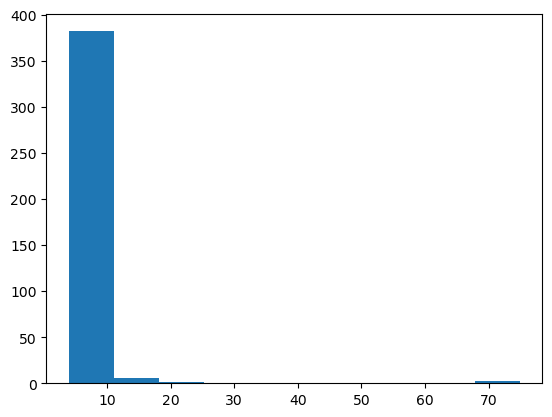

In [34]:
plt.hist(ppt_means[:,4],bins=10)

In [49]:
# Just checking that the features and targets have the same shape. 
print(len(features), len(targets))
print(features[10].shape, len(targets[10]))

88 88
(383, 95) 383


We start by just training a two class classifier for Alzheimer's vs Healthy. It is easy to see that the first 65 patients correspond to those two classes so we will first use those two. 

In [50]:
cross_valid_acc = []
confusion_matrices = []
for i in range(65):
    # The following two arrays will store the target and features for the train set. We will append to it
    # as we go through various subjects. 
    train_X = np.concatenate(features[:i] + features[i+1:65])
    train_y = np.concatenate(targets[:i] + targets[i+1:65])
    
    
    # The following two arrays will store target and features for the test set. 
    test_X = features[i]
    test_y = targets[i]
    
    # scaling the features to make sure they have same mean and standard deviation
    
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    
    # We now train the classifier on the test data
    ThreeNN = KNeighborsClassifier(n_neighbors=3)
    ThreeNN.fit(train_X, train_y)
    
    
    test_X = scaler.transform(test_X)
    
    # This stores the accuracy on the test data
    cross_valid_acc += [ThreeNN.score(test_X, test_y)]
    confusion_matrices += [confusion_matrix(test_y,ThreeNN.predict(test_X))]


In [51]:
confusion_matrices = np.array(confusion_matrices)
total_confusion = np.sum(confusion_matrices, axis= 0)
total_confusion

array([[9290, 5224],
       [4017, 7995]], dtype=int64)

In [52]:
total = np.sum(total_confusion)
acc = (total_confusion[0,0] +total_confusion[1,1])/total
sens = total_confusion[0,0]/(total_confusion[0,0]+total_confusion[0,1])
spec = total_confusion[1,1]/(total_confusion[1,1]+total_confusion[1,0])
prec = total_confusion[0,0]/(total_confusion[0,0]+total_confusion[1,0])
f1 = 2*(prec*sens)/(prec+sens)

In [53]:
print((acc,sens,spec,f1))

(0.6516248209304079, 0.6400716549538377, 0.6655844155844156, 0.6678408396534992)


In [33]:
confusion_matrices = np.array(confusion_matrices)
total_confusion = np.sum(confusion_matrices, axis= 0)
total_confusion

array([[9290, 5224],
       [4017, 7995]], dtype=int64)

In [34]:
total = np.sum(total_confusion)
acc = (total_confusion[0,0] +total_confusion[1,1])/total
sens = total_confusion[0,0]/(total_confusion[0,0]+total_confusion[0,1])
spec = total_confusion[1,1]/(total_confusion[1,1]+total_confusion[1,0])
prec = total_confusion[0,0]/(total_confusion[0,0]+total_confusion[1,0])
f1 = 2*(prec*sens)/(prec+sens)

In [35]:
print((acc,sens,spec,f1))

(0.6516248209304079, 0.6400716549538377, 0.6655844155844156, 0.6678408396534992)


In [79]:
cross_valid_acc[0:5]

[0.6510067114093959,
 0.45569620253164556,
 0.5526315789473685,
 0.8977272727272727,
 0.513715710723192]

In [80]:
np.mean(cross_valid_acc), np.std(cross_valid_acc)

(0.6668528055353906, 0.2222600102467725)

Now we train a three class classifier on the same data. 

In [74]:
cross_valid_acc_3class = []
for i in range(len(target_labels)):
    
    # The following two arrays will store the target and features for the train set. We will append to it
    # as we go through various subjects. 
    train_X = np.concatenate(features[:i] + features[i+1:])
    train_y = np.concatenate(targets[:i] + targets[i+1:])
    
    
    # The following two arrays will store target and features for the test set. 
    test_X = features[i]
    test_y = targets[i]
    
    # scaling the features to make sure they have same mean and standard deviation
    
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    
    # We now train the classifier on the test data
    ThreeNN = KNeighborsClassifier(n_neighbors=3)
    ThreeNN.fit(train_X, train_y)
    
    
    test_X = scaler.transform(test_X)
    
    # This stores the accuracy on the test data
    cross_valid_acc_3class += [ThreeNN.score(test_X, test_y)]


In [75]:
cross_valid_acc_3class[0:10]

[0.5637583892617449,
 0.35443037974683544,
 0.4342105263157895,
 0.4914772727272727,
 0.513715710723192,
 0.17777777777777778,
 0.599476439790576,
 0.8025316455696202,
 0.3770491803278688,
 0.1674491392801252]

In [76]:
np.mean(cross_valid_acc_3class), np.std(cross_valid_acc_3class)

(0.45720000208854844, 0.25162364663428294)